In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
class Product:
    INK = 'SQUID_INK'


In [3]:
prices = pd.concat([pd.read_csv(f'round4/prices_round_4_day_{i}.csv', sep=';') for i in range(1, 4)], ignore_index=True)
trades = pd.concat([pd.read_csv(f'round4/trades_round_4_day_{i}_nn.csv', sep=';') for i in range(1, 4)], ignore_index=True)
observations = []
for day in range(1, 4):
    odf = pd.read_csv(f'round4/observations_round_4_day_{day}.csv')
    odf['day'] = day
    observations.append(odf)
observations = pd.concat(observations, ignore_index=True)

In [4]:
ink = prices[prices['product'] == Product.INK].reset_index(drop=True).copy()
ink['time'] = ink['timestamp'] + (ink['day'] - 1) * 1_000_000

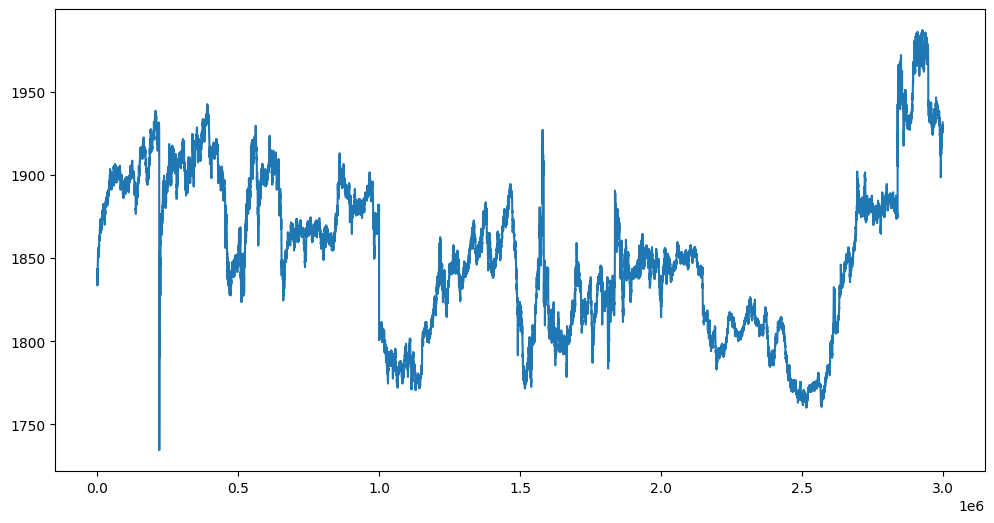

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(ink['time'], ink['mid_price'])
plt.show()

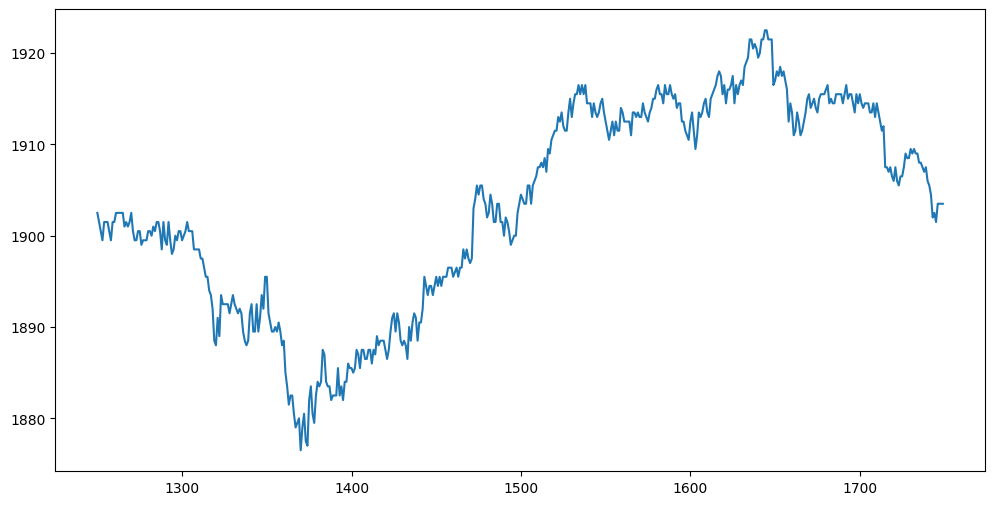

In [6]:
'''browse'''
# big spike window
data = ink[ink['day'] == 1].copy()
df = data.iloc[1250:1750]

# browse = ink.iloc[3000:10000]
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['mid_price'])
plt.show()

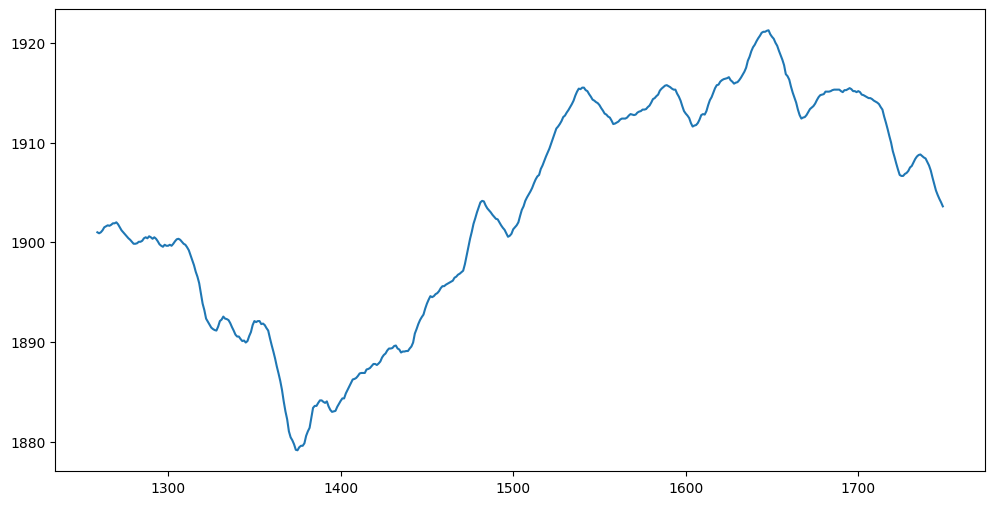

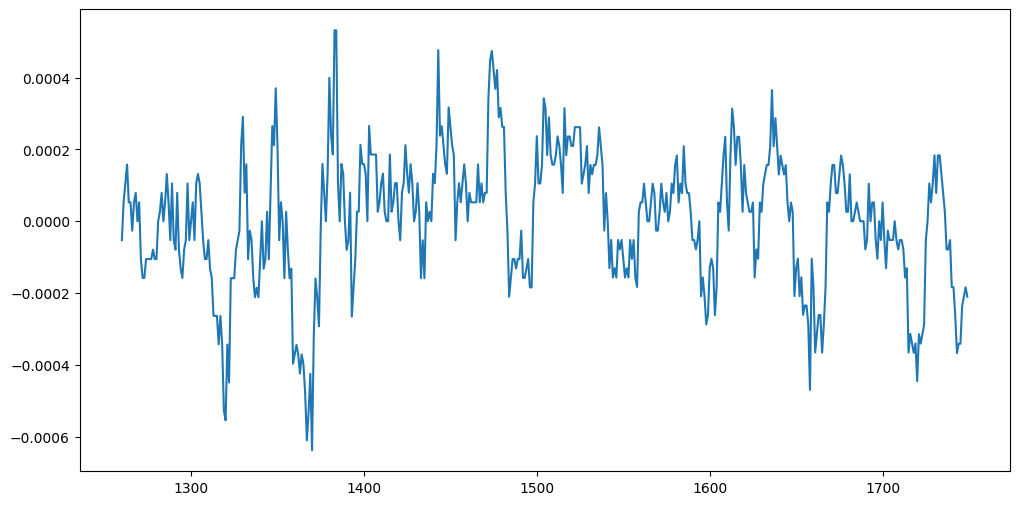

In [8]:
# browse = ink.iloc[3000:10000]
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['mid_price'].rolling(10).mean())
plt.show()

plt.figure(figsize=(12, 6))
# plt.plot(df.index, df['mid_price'].pct_change())
plt.plot(df.index, df['mid_price'].rolling(10).mean().pct_change())
plt.show()

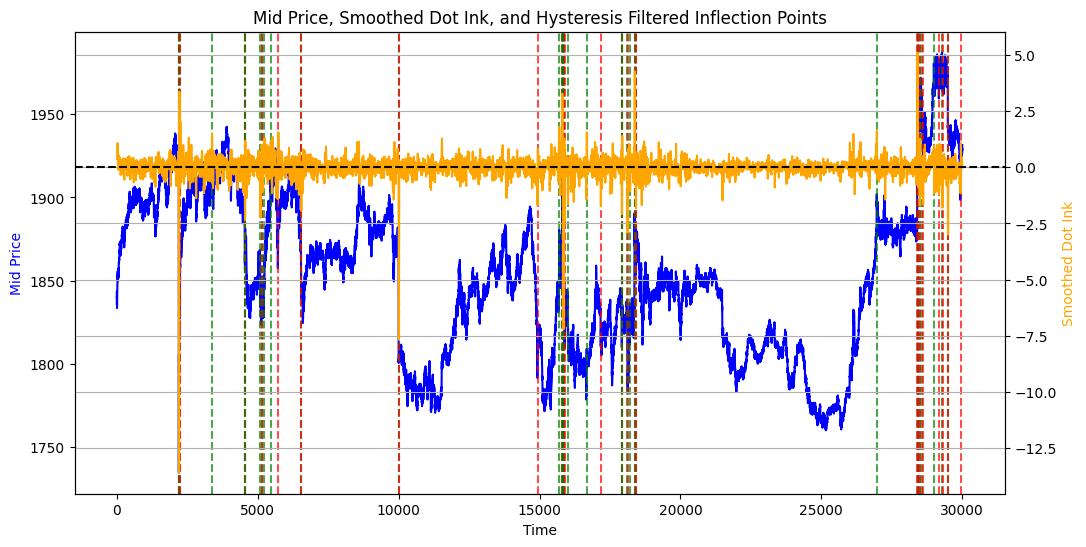

In [16]:
def hysteresis_filter(series, high_thresh=0.001, low_thresh=0.0005):
    dot_dot = series.dropna()
    idxs = dot_dot.index
    values = dot_dot.values

    signals = []
    can_signal_pos = True
    can_signal_neg = True

    for i in range(len(values)):
        val = values[i]
        idx = idxs[i]

        if can_signal_pos and val > high_thresh:
            signals.append(('positive', idx))
            can_signal_pos = False  # turn off until we fall below low_thresh
        elif val < low_thresh:
            can_signal_pos = True

        if can_signal_neg and val < -high_thresh:
            signals.append(('negative', idx))
            can_signal_neg = False
        elif val > -low_thresh:
            can_signal_neg = True

    return pd.Series(signals)

def plot_ink_with_hysteresis(mid_price, dot_ink, dot_dot_ink, high_thresh=.5, low_thresh=0.05):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax2 = ax1.twinx()

    # Plot mid_price on the primary axis
    ax1.plot(mid_price.index, mid_price, label='Mid Price', color='blue')

    # Plot smoothed dot_ink on the secondary axis
    ax2.plot(dot_ink.index, dot_ink, label='Smoothed Dot Ink', color='orange')

    # Draw a black line where dot_ink is zero
    ax2.axhline(0, color='black', linestyle='--', label='Dot Ink = 0')

    # Apply hysteresis filtering to dot_dot_ink
    filtered_signals = hysteresis_filter(dot_dot_ink, high_thresh, low_thresh)

    # Plot vertical lines at inflection points
    for signal, idx in filtered_signals.dropna():
        if signal == 'positive':
            ax1.axvline(x=idx, color='red', linestyle='--', alpha=0.7, label='Negative Inflection Point')
        elif signal == 'negative':
            ax1.axvline(x=idx, color='green', linestyle='--', alpha=0.7, label='Positive Inflection Point')

    # Set labels and title
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Mid Price', color='blue')
    ax2.set_ylabel('Smoothed Dot Ink', color='orange')
    plt.title('Mid Price, Smoothed Dot Ink, and Hysteresis Filtered Inflection Points')

    # Add legends
    # ax1.legend(loc='upper left')
    # ax2.legend(loc='upper right')

    plt.grid()
    plt.show()

# Call the function with ink['mid_price'], dot_ink, and dot_dot_ink
plot_ink_with_hysteresis(ink['mid_price'], dot_ink, dot_dot_ink)


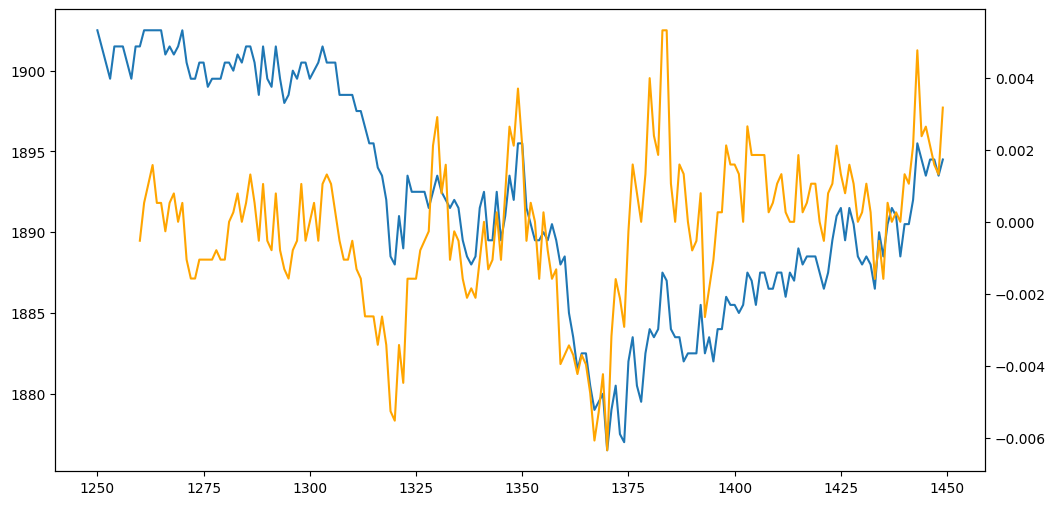

In [9]:
# browse = ink.iloc[3000:10000]
df = data.iloc[1250:1450]
# df = data.iloc[1250:1750]
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['mid_price'])
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(df.index, df['mid_price'].pct_change())
plt.twinx()
# plt.plot(df.index, df['mid_price'].pct_change(10).rolling(10).mean(), color='orange')
plt.plot(df.index, df['mid_price'].pct_change(10), color='orange')
plt.show()

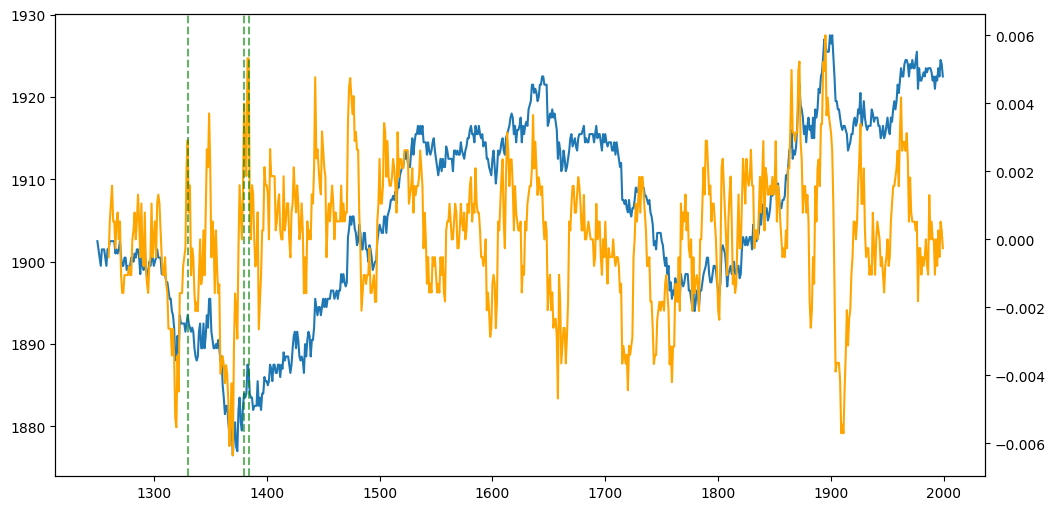

In [ ]:
# df = data.iloc[1250:1450].copy()
df = data.iloc[1250:2000].copy()
pct_change_10 = df['mid_price'].pct_change(10)

# Find the inflection point where the pct_change goes from negative to positive
# TODO could also use threshold for abs value of pct change
# inflection_points = (pct_change_10.shift(1) < 0) & (pct_change_10 > 0) & (pct_change_10.abs() > 0.01)
# inflection_points = (pct_change_10.shift(1) < 0) & (pct_change_10 > 0) & (abs(pct_change_10 - pct_change_10.shift(1)) >= 0.008)
positive_inflection = (pct_change_10.shift(10) < 0) & (pct_change_10 > 0) & (pct_change_10 - pct_change_10.shift(10) >= 0.008)
positive_inflection_indices = df.index[positive_inflection]

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['mid_price'], label='Mid Price')

ax2 = plt.gca().twinx()
ax2.plot(df.index, pct_change_10, color='orange', label='10-step % Change')

# Plot vertical lines at inflection points
for idx in positive_inflection_indices:
    plt.axvline(x=idx, color='green', linestyle='--', alpha=0.6)

plt.show()


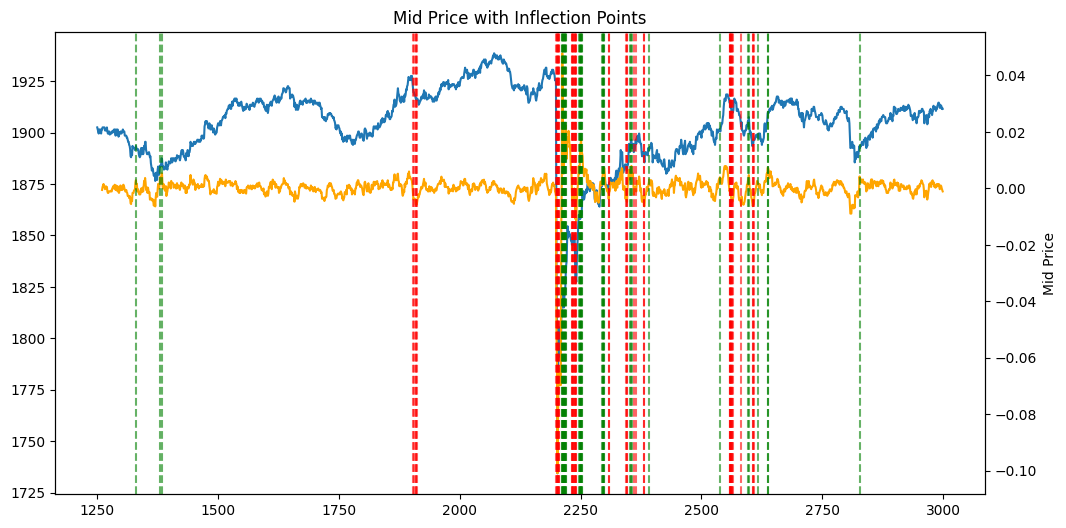

In [13]:
# df = data.iloc[1250:1450].copy()
df = data.iloc[1250:3000].copy()
pct_change_10 = df['mid_price'].pct_change(10)

# Find the inflection point where the pct_change goes from negative to positive
# TODO could also use threshold for abs value of pct change
# inflection_points = (pct_change_10.shift(1) < 0) & (pct_change_10 > 0) & (pct_change_10.abs() > 0.01)
# inflection_points = (pct_change_10.shift(1) < 0) & (pct_change_10 > 0) & (abs(pct_change_10 - pct_change_10.shift(1)) >= 0.008)

inflection_threshold = 0.008

positive_inflection = (pct_change_10.shift(10) < 0) & (pct_change_10 > 0) & (pct_change_10 - pct_change_10.shift(10) >= inflection_threshold)
positive_inflection_indices = df.index[positive_inflection]
negative_inflection = (pct_change_10.shift(10) > 0) & (pct_change_10 < 0) & (pct_change_10.shift(10) - pct_change_10 >= inflection_threshold)
negative_inflection_indices = df.index[negative_inflection]

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['mid_price'], label='Mid Price')

ax2 = plt.gca().twinx()
ax2.plot(df.index, pct_change_10, color='orange', label='10-step % Change')

# Plot vertical lines at inflection points
for idx in positive_inflection_indices:
    plt.axvline(x=idx, color='green', linestyle='--', alpha=0.6)

for idx in negative_inflection_indices:
    plt.axvline(x=idx, color='red', linestyle='--', alpha=0.6)
plt.title('Mid Price with Inflection Points')
plt.xlabel('Index')
plt.ylabel('Mid Price')

plt.show()


In [21]:
velocity = df['mid_price'].diff()
acceleration = velocity.diff()

/var/folders/9p/y7yhf54d2yd5cdpt7hc80f2h0000gn/T/ipykernel_44414/1249112922.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['momentum'] = df['mid_price'].diff(lookback)
/var/folders/9p/y7yhf54d2yd5cdpt7hc80f2h0000gn/T/ipykernel_44414/1249112922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = np.where(df['momentum'] > threshold, 1,
/var/folders/9p/y7yhf54d2yd5cdpt7hc80f2h0000gn/T/ipykernel_44414/1249112922.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

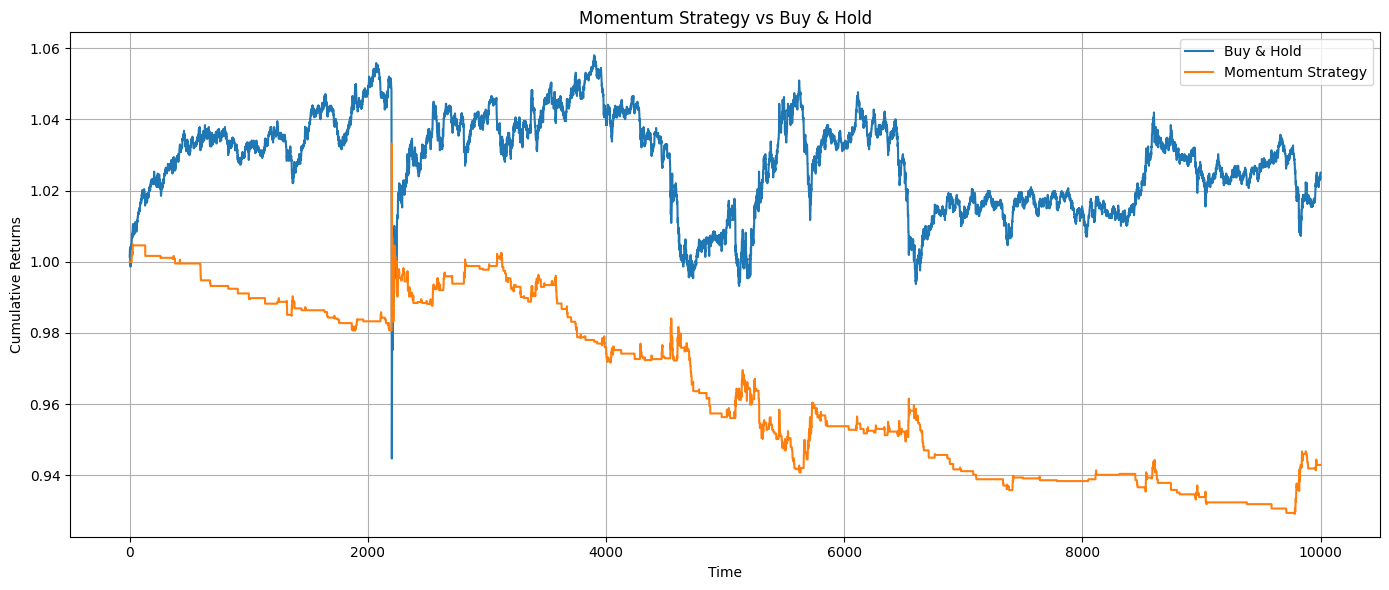

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Momentum calculation ---
lookback = 10
df['momentum'] = df['mid_price'].diff(lookback)

# --- Create a simple momentum-based signal ---
threshold = df['momentum'].std()
df['signal'] = np.where(df['momentum'] > threshold, 1,
                        np.where(df['momentum'] < -threshold, -1, 0))

# --- Simulated strategy returns ---
df['returns'] = df['mid_price'].pct_change()
df['strategy_returns'] = df['signal'].shift(1) * df['returns']
df['cumulative_strategy'] = (1 + df['strategy_returns']).cumprod()
df['cumulative_returns'] = (1 + df['returns']).cumprod()

# --- Plotting ---
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['cumulative_returns'], label='Buy & Hold')
plt.plot(df.index, df['cumulative_strategy'], label='Momentum Strategy')
plt.title("Momentum Strategy vs Buy & Hold")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: >

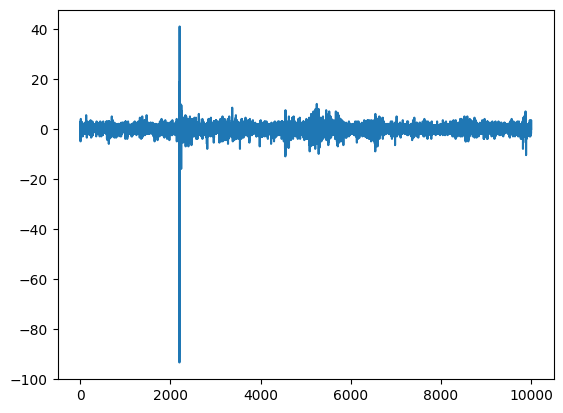

In [9]:
velocity.plot()

<Axes: >

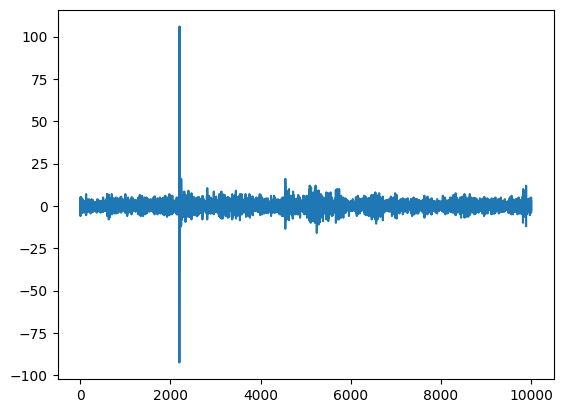

In [10]:
acceleration.plot()